In [1]:
from IPython.display import Image
%matplotlib inline
import pandas as pd
from pathlib import Path

#禁用科学计数法
pd.set_option('display.float_format',lambda x : '%.2f' % x)

#设置数据文件夹路径
DATA = Path().resolve()  / 'data'

# 线性回归简介

## 简单线性回归

简单（单变量）线性回归的目的是针对单个特征（解释变量x）和连续目标值（响应变量y）之间的关系建模。拥有一个解释变量的线性回归模型的方程定义如下：

$$y=w_0+w_1x$$

这里权重w0代表y轴截距，w1为解释变量的权重系数。我们的目标是学习线性方程的权重，以描述解释变量和目标变量之间的关系，然后预测训练数据集里未见过的新响应变量。根据前面的定义，线性回归可以理解为通过采样点找到最佳拟合直线，如图所示。

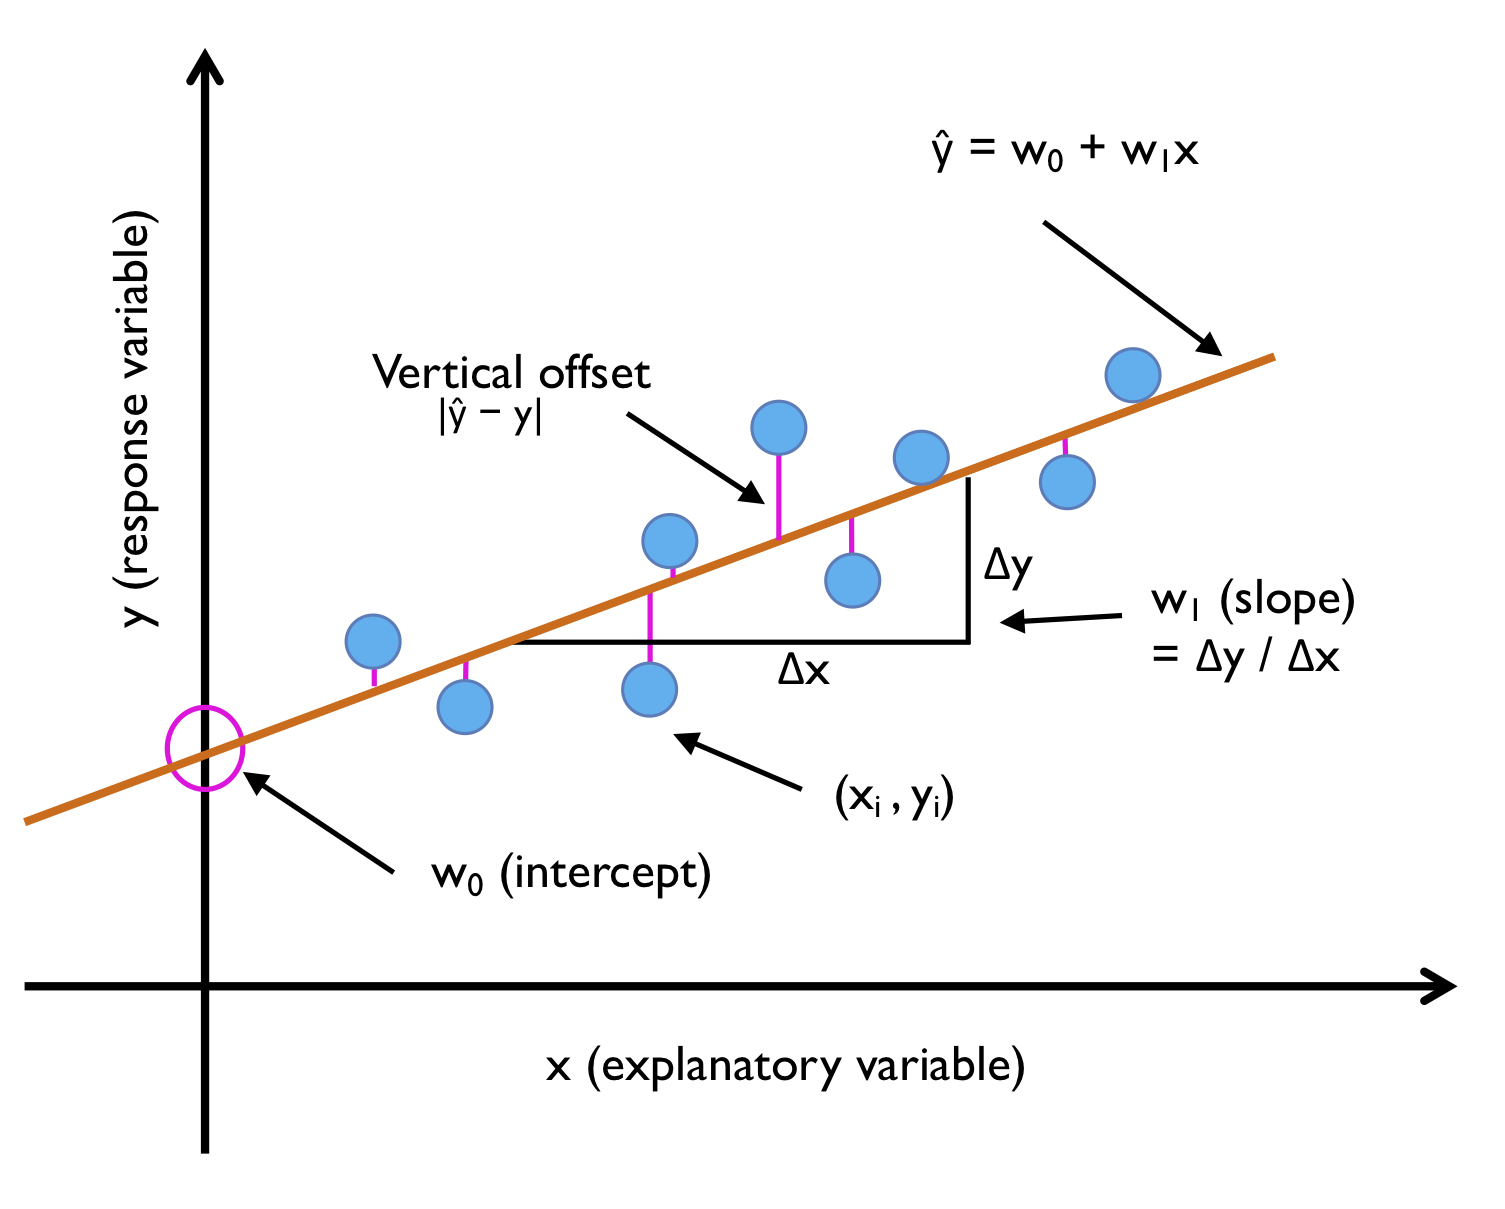

In [2]:
Image(filename='images/10_01.png', width=500) 

## 多元线性回归

也可以将线性回归模型推广到多个解释变量，这个过程叫作多元线性回归。

# 探索住房数据集

## 加载住房数据

住房数据集中所包含的506个样本的特征，来源于先前共享的[原始数据源](https://archive.ics.uci.edu/ml/datasets/Housing)：
- CRIM：城镇人均犯罪率。
- ZN：占地面积超过25000平方英尺（1平方英尺＝0.092903平方米）的住宅用地比例。
- INDUS：城镇非零售营业面积占比。
- CHAS：查尔斯河虚拟变量（如果是界河，值为1，否则为0）。
- NOX：一氧化氮浓度（每千万分之一）。
- RM：平均每户的房间数。
- AGE：1940年以前建造的业主自住房屋比例。
- DIS：房屋距离波士顿五个就业中心的加权距离。
- RAD：辐射公路可达性指数。
- TAX：每10000美元全额财产的税率。
- PTRATIO：城镇师生比例。B：1000（Bk-0.63）2，其中Bk是城镇中非裔美国人的比例。
- LSTAT：弱势群体人口的百分比。
- MEDV：业主自住房的中位价（以1000美元为单位）。

我们将在本章的其余部分把房价（MEDV）作为目标变量，即基于13个解释变量中的1个或多个来预测房价。

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/' 'machine-learning-databases' '/housing/housing.data', sep='\s+') 
# df = pd.read_csv(DATA/'housing.data.txt', header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.03,0.00,7.07,0,0.47,6.42,78.90,4.97,2,242.00,17.80,396.90,9.14,21.60
1,0.03,0.00,7.07,0,0.47,7.18,61.10,4.97,2,242.00,17.80,392.83,4.03,34.70
2,0.03,0.00,2.18,0,0.46,7.00,45.80,6.06,3,222.00,18.70,394.63,2.94,33.40
3,0.07,0.00,2.18,0,0.46,7.15,54.20,6.06,3,222.00,18.70,396.90,5.33,36.20
4,0.03,0.00,2.18,0,0.46,6.43,58.70,6.06,3,222.00,18.70,394.12,5.21,28.70


<hr>

### Note:


You can find a copy of the housing dataset (and all other datasets used in this book) in the code bundle of this book, which you can use if you are working offline or the UCI server at https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data is temporarily unavailable. For instance, to load the housing dataset from a local directory, you can replace the lines
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/housing/housing.data',
                 sep='\s+')
in the following code example by 
df = pd.read_csv('./housing.data',
                 sep='\s+')

## 可视化数据集

探索性数据分析（EDA）是在进行机器学习模型训练之前值得推荐的重要一步。在本节的其余部分，我们将使用图形化EDA工具箱中的一些简单而有用的技术，这些技术有助于直观地发现异常值、数据分布以及特征之间的关系。

调用[MLxtend库](http://rasbt.github.io/mlxtend/)的scatterplotmatrix函数绘制散点图矩阵，这是包含机器学习和数据科学应用各种便捷功能的Python库。

In [5]:
#!pip install mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

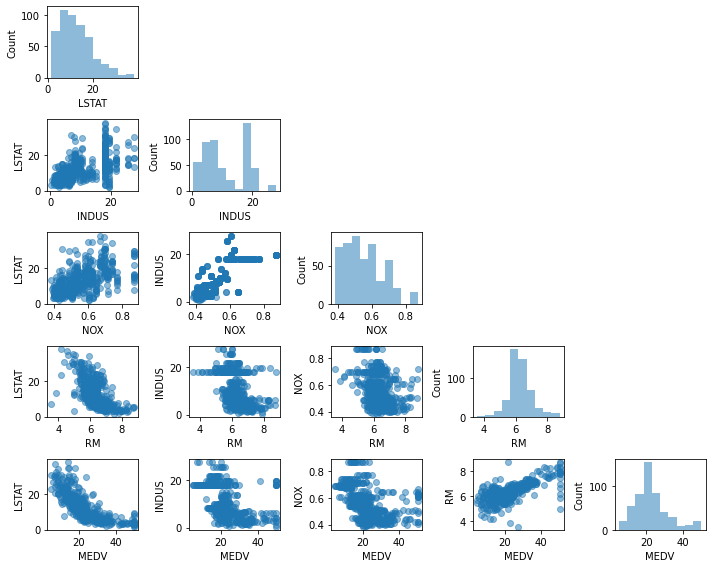

In [6]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

scatterplotmatrix(df[cols].values, figsize=(10, 8), 
                  names=cols, alpha=0.5)
plt.tight_layout()
#plt.savefig('images/10_03.png', dpi=300)
plt.show()

可以利用散点图矩阵快速分辨出数据的分布情况以及是否含有异常值。
- 例如，可以看到房间数RM和房价MEDV（第四行第五列）之间存在着线性关系。
- 此外，我们还可以从散点图矩阵右下角的直方图看到，MEDV变量似乎呈正态分布，但包含了几个异常值。

## 用相关矩阵查看关系

相关矩阵与5.1节介绍的协方差矩阵密切相关。直观地说，我们可以把相关矩阵理解为对协方差矩阵的修正。事实上，相关矩阵与协方差矩阵在标准化特征计算方面保持一致。

相关矩阵是包含皮尔逊积矩相关系数（通常简称为皮尔逊r）的方阵，我们用它来度量特征对之间的线性依赖关系。相关系数的值在-1到1之间。
- 如果r=1，则两个特征之间呈完美的正相关；
- 如果r=0，则两者之间没有关系；
- 如果r=-1，则两者之间呈完全负相关的关系。

标准化的特征之间的协方差实际上等于它们的线性相关系数。

调用NumPy的corrcoef函数处理前面可视化散点图矩阵的5个特征列，调用MLxtend的heatmap函数绘制相关矩阵对应的热度图：

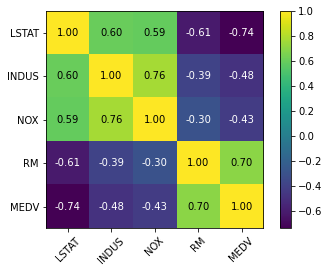

In [7]:
import numpy as np
from mlxtend.plotting import heatmap


cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

# plt.savefig('images/10_04.png', dpi=300)
plt.show()

为了拟合线性回归模型，我们只对那些与目标变量MEDV高度相关的特征感兴趣。分析前面的相关矩阵，我们发现**目标变量MEDV与变量LSTAT**（-0.74）之间的相关性最大。

然而，可能你还记得在检查散点图矩阵时，我们曾经发现LSTAT和MEDV之间存在着明显的**非线性关系**。

另一方面，**RM和MEDV之间的相关性**相对来说也比较高（0.70）。因为从散点图观察到两个变量之间存在着线性关系，RM似乎是下面要介绍的简单线性回归模型中探索变量的合适选择。

# 普通最小二乘

线性回归模型的实现在本章的开头部分，我们提到过可以把线性回归理解为通过训练数据的样本点获得最佳拟合直线。然而，我们既没有定义最佳拟合（best-fitting），也没有讨论过拟合模型的不同技术。下面的小节，我们将用普通最小二乘（OLS）法（有时也称为线性最小二乘）来填补缺失的部分并估计线性回归的参数，从而使样本点与线的垂直距离（残差或误差）之平方和最小。

## 用梯度下降方法求解回归参数

自适应线性神经元（Adaline）。同时，我们还定义了代价函数J（w），并通过优化算法来最小化代价函数的学习权重，这些算法包括梯度下降（GD）和随机梯度下降（SGD）。Adaline的代价函数是误差平方和（SSE），它与OLS所用的代价函数相同。

OLS回归基本上可以理解为没有单位阶跃函数的Adaline，这样我们就可以得到连续的目标值，而不是分类标签-1和1。以Adaline GD实现为基础，去除单位阶跃函数来实现第一个线性回归模型：

In [8]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

为了观察LinearRegressionGD回归器的具体实现，我们用住房数据的RM（房间数）变量作为解释变量，训练可以预测MEDV（房价）的模型。此外通过标准化变量以确保GD算法具有更好的收敛性。示例代码如下：

In [9]:
X = df[['RM']].values
y = df['MEDV'].values

用np.newaxis和flatten变通y_std的方法。scikit-learn的大多数转换器期望数据存储在二维数组中。

用y［:,np.newaxis］为数组添加了一个新维度。然后，StandardScaler返回缩放后的变量，为了方便用flatten()方法将其转换回原来的一维数组。

In [10]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [11]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

将代价作为训练数据集上迭代次数的函数，用诸如梯度下降这样的优化算法来检查是否收敛到了最低代价（这里指的是全局性最小代价值），以此为基础绘制代价图确实是个不错的主意：

GD算法在第五次迭代后开始收敛。

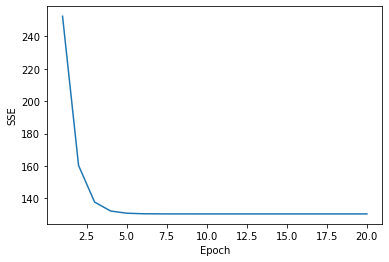

In [12]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
#plt.tight_layout()
#plt.savefig('images/10_05.png', dpi=300)
plt.show()

我们通过可视化手段，观察线性回归与训练数据的拟合程度。

In [13]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

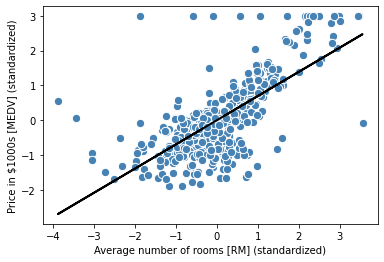

In [14]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')

#plt.savefig('images/10_06.png', dpi=300)
plt.show()

在许多情况下，房间数目并不能很好地解释房价：在y=3的时候有几个数据点形成了一个横排，这表明价格对房间数目可能已经不再敏感。

将预测结果变量以原始缩放进行报告也很重要。我们可以直接调用StandardScaler的inverse_transform方法，把我们对价格预测的结果恢复到以Price in $1000s坐标轴上：

In [15]:
from distutils.version import LooseVersion
import sklearn


num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)

if LooseVersion(sklearn.__version__) >= LooseVersion('0.23.0'):
    print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std[:, np.newaxis]).flatten())
else:
    print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


如果我们处理标准化变量，从技术角度来说，并不需要更新截距的权重，因为在这种情况下，y轴的截距总是0。因此可以通过显示权重来快速确认：

In [16]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: 0.000


## 通过scikit-learn估计回归模型的系数

许多用于回归的scikit-learn估计器都采用SciPy（scipy.linalg.lstsq）中的最小二乘法来实现，而后者又采用在线性代数包（LAPACK）的基础上高度优化过的代码进行优化。

scikit-learn中所实现的线性回归也可以（更好）用于未标准化的变量，因为它不采用基于（S）GD的优化，因此我们**可以跳过标准化**的步骤：

In [17]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.103
Intercept: -34.677


由于函数尚未标准化，因此scikit-learn的LinearRegression模型（使用未标准化的RM和MEDV变量进行筛选）产生了不同的模型系数。

通过绘制MEDV与RM的关系图来将其与GD实现进行比较时，可以定性地看到它也能很好地拟合数据：

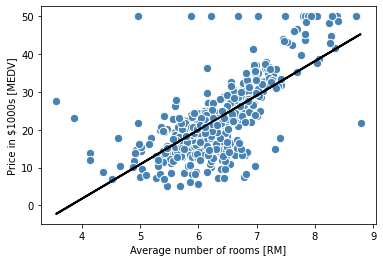

In [18]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

#plt.savefig('images/10_07.png', dpi=300)
plt.show()

### 线性回归的分析解

除机器学习库外，另一个选择是用封闭形态的OLS解决方案，这涉及线性方程组，可以从大多数入门级统计教科书中找到相应的介绍。

这种方法的优点是保证能通过分析找到最优解。但是，如果我们面对的是非常大的数据集，那么在该公式中矩阵求逆（有时也称为正规方程）计算可能就非常昂贵，包含训练样本的矩阵有可能成为奇异矩阵（不可逆），这就是在某些情况下我们可能更喜欢迭代的原因。

In [19]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.103
Intercept: -34.677


# 利用RANSAC拟合鲁棒回归模型

线性回归模型可能会受到异常值的严重影响。在某些情况下，一小部分数据可能会对估计的模型系数有很大的影响。

除了淘汰异常值之外，我们还有一种鲁棒回归方法，即随机抽样一致性（RANdomSAmple Consensus，RANSAC）算法，根据数据子集（所谓的内点，inlier）来拟合回归模型。

RANSAC(RAndom SAmple Consensus,随机采样一致)算法是从一组含有“外点”(outliers)的数据中正确估计数学模型参数的迭代算法。“外点”一般指的的数据中的噪声，比如说匹配中的误匹配和估计曲线中的离群点。所以，RANSAC也是一种“外点”检测算法。RANSAC算法是一种不确定算法，它只能在一种概率下产生结果，并且这个概率会随着迭代次数的增加而加大（之后会解释为什么这个算法是这样的）。RANSAC算最早是由Fischler和Bolles在SRI上提出用来解决LDP(Location Determination Proble)问题的。

对于RANSAC算法来说一个基本的假设就是数据是由“内点”和“外点”组成的。“内点”就是组成模型参数的数据，“外点”就是不适合模型的数据。同时RANSAC假设：在给定一组含有少部分“内点”的数据，存在一个程序可以估计出符合“内点”的模型。

总结迭代RANSAC算法如下：
1. 随机选择一定数量的样本作为内点来拟合模型。
2. 用模型测试所有其他的数据点，把落在用户给定公差范围内的点放入内点集。
3. 用内点重新拟合模型。
4. 估计模型预测结果与内点集相比较的误差。
5. 如果性能达到用户定义的阈值或指定的迭代数则终止算法；否则返回到步骤1。

用scikit-learn的RANSACRegressor类实现基于RANSAC算法的线性模型：

- RANSACRegressor的最大迭代次数为100，
- min_samples=50设置随机选择的最小样本数量为50。
- 'absolute_loss'作为形式参数loss的实际参数，该算法计算拟合线和采样点之间的绝对垂直距离。
- residual_threshold参数设置为5.0，使内点集仅包括与拟合线垂直距离在5个单位以内的采样点，这对特定数据集的效果很好。

In [21]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_error', 
                         residual_threshold=5.0, 
                         random_state=0)


ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=0, residual_threshold=5.0)

默认情况下，scikit-learn用MAD估计内点选择的阈值，MAD是目标值y的中位数绝对偏差（Median Absolute Deviation）的缩写。然而，选择适当的内点阈值将因问题而异，这是RANSAC的不利之处。

拟合RANSAC模型之后，我们可以根据用RANSAC算法拟合的线性回归模型获得内点和异常值，并且把这些点与线性拟合的情况绘制成图：

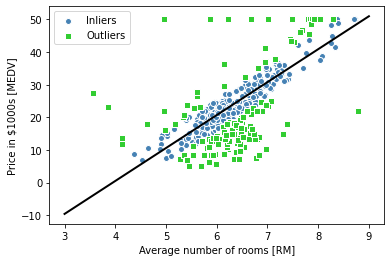

In [22]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

#plt.savefig('images/10_08.png', dpi=300)
plt.show()

In [24]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


在利用模型计算出斜率和截距之后，我们可以看到线性回归拟合的线与前一节未用RANSAC拟合的结果有些不同：

RANSAC降低了数据集中异常值的潜在影响，但是，我们并不知道这种方法对未见过数据的预测性能是否有良性影响。

# 评估线性回归模型的性能

不再使用简单回归模型，而是用数据集中的所有变量来训练多元回归模型：

In [24]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [25]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

由于模型使用了多个解释变量，因此我们无法在二维图中可视化线性回归线（或者更准确地说是超平面），

但是可以通过绘制**残差**（实际值和预测值之间的差异或垂直距离）与预测值来判断回归模型。残差图是判断回归模型常用的图形工具。这有助于检测非线性和异常值，并检查这些误差是否呈随机分布。

In [26]:
import numpy as np
import scipy as sp

ary = np.array(range(100000))

In [27]:
%timeit np.linalg.norm(ary)

58.4 µs ± 870 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
%timeit sp.linalg.norm(ary)

62.9 µs ± 2.16 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
%timeit np.sqrt(np.sum(ary**2))

82.7 µs ± 361 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


绘制出残差图，这里的残差为预测值直接减去真实目标变量，残差图中有一条线通过x轴原点：

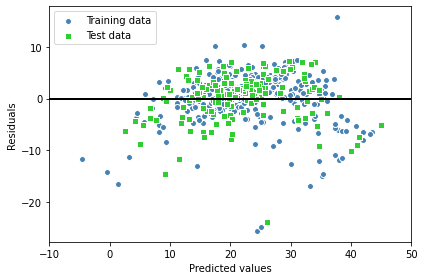

In [30]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

我们期望好的回归模型的误差呈随机分布，残差应该随机分布在中心线附近。如果从残差图中看到模式存在，就意味着模型无法捕捉到一些解释性信息，这些信息已经泄露到了残差中，如前面的残差图所示。

此外，我们还可以用残差图来检测异常值点，这些异常值点由图中与中心线存在很大偏差的那些点来表示。

另一个有用的模型性能定量度量是所谓的均方误差（MSE），它仅仅是为了拟合线性回归模型而将SSE代价平均值最小化的结果。

MSE对比较不同的回归模型或通过网格搜索和交叉验证调整其参数很有用，因为我们通过样本规模归一化SSE。

In [32]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))

MSE train: 22.390, test: 21.382


训练数据集的MSE为19.96，而测试数据集的MSE为27.20，**测试数据集的MSE比较大**，这是模型**过拟合**训练数据的标志。

但是，请注意，例如，与分类准确率相比，MSE不受限制。换句话说，对MSE的解释取决于**数据集和特征缩放**。

决定系数（$R^2$）可能更为有用，我们可以把这理解为MSE的标准版，其目的是为更好地解释模型的性能。换句话说，R2是模型捕获到的响应方差函数的一部分。

对于训练数据集，R2的取值范围在0到1之间，但是它也可以是负值。如果 $R^2=1$，当相应的MSE=0时，模型可以完美地拟合数据。

In [34]:
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

R^2 train: 0.741, test: 0.728


在训练数据集上进行评估，我们获得模型的 $R^2$ 为0.765，这听起来并不太坏。但是，在测试数据集上进行评估，我们所获得的 $R^2$ 只有0.673

# 用正则化方法进行回归

正则化是通过添加额外信息解决过拟合问题的一种方法，而缩小模型参数值却引来复杂性的惩罚。正则线性回归最常用的方法包括所谓的岭回归、最小绝对收缩与选择算子（LASSO）以及弹性网络（ElasticNet）。

### 岭回归
岭回归是一个L2惩罚模型，只需要把加权平方添加到最小二乘代价函数。通过加大超参数λ的值，增加正则化的强度，同时收缩模型的权重。

适用：预测变量很多，且系数大致相等。可有效缩小系数。

### LASSO
另一种可能导致稀疏模型的方法是LASSO。取决于正则化的强度，某些权重可能成为零，这也使LASSO成为监督特征选择的有用技术，对LASSO的L1惩罚定义为模型权重的绝对值之和。

LASSO的局限性在于，如果m>n，则最多可以选择n个特征，其中n为训练样本的数量。这在特征选择的某些应用中可能是不希望的。

但是，LASSO的这种属性实际上是一个优势，因为它避免了模型饱和。如果训练样本的数量与特征的数量相同，就会出现模型饱和问题，这是过参数化的一种现象。因此，虽然饱和模型总能完美地拟合训练数据，但是这仅仅是插值的一种形式，无法泛化。

适用：某些预测变量系数较大，而其余预测变量系数较小。因为可以将某些系数设置为0，因此可产生更简洁更易解释的模型。

### 弹性网络

弹性网络是在岭回归和LASSO之间的折中，它以L1惩罚产生稀疏性，以L2惩罚用于选择n个以上的特征，条件是m>n。

适用：
- 当多个特征和另一特征相关时，弹性网络非常有用。Lasso 倾向于随机选择其中一个，而弹性网络更倾向于选择两个。
- 对所选变量的数量没有限制。

In [35]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-8.77980402e-02  4.78098875e-02 -0.00000000e+00  9.66095417e-01
 -0.00000000e+00  3.70405059e+00  2.20191910e-03 -9.51823747e-01
  2.14572342e-01 -1.15356514e-02 -8.70277294e-01  8.06193238e-03
 -6.22571499e-01]


In [36]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 23.690, test: 22.295
R^2 train: 0.726, test: 0.717


初始化岭回归模型，正则化强度依靠参数alpha的调节，类似于参数λ

In [37]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

初始化LASSO回归

In [38]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

实现ElasticNet能够调整L1与L2的比例。如果我们把l1_ratio设置为1.0，那么ElasticNet回归等同于LASSO回归。

In [39]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

# 将线性回归模型转换为曲线——多项式回归

前面假设解释变量和响应变量之间存在着线性关系。一种有效解决违背线性假设的方法是，通过增加多项式项利用多项式回归模型。

虽然可以用多项式回归来模拟非线性关系，但是因为存在线性回归系数w，它仍然被认为是多元线性回归模型。

## 用scikit-learn增加多项式项

scikit-learn的PolynomialFeatures转换类在只含一个解释变量的简单回归问题中增加二次项（d=2）。

然后根据下面的步骤来比较多项式拟合与线性拟合：

In [43]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [44]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()

# 增加一个二次多项式项
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

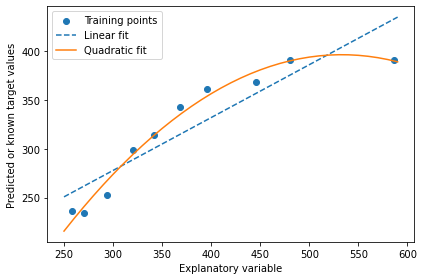

In [46]:
# 为了比较，拟合一个简单线性回归模型
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# 用转换后的特征针对多项式回归拟合一个多元回归模型
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# 绘制结果
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/10_11.png', dpi=300)
plt.show()

In [47]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [48]:
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


计算MSE和R2评估指标

MSE从570（线性拟合）下降到61（二次项拟合）；同时，对这个特定问题，决定系数反映出二次项模型拟合（R2=0.982）比线性拟合（R2=0.832）更加合适。

## 为住房数据集中的非线性关系建模

学习了如何构建多项式特征以拟合非线性关系后，现在我们可以通过一个更具体的例子，将这些概念应用于住房数据集。

用二次和三次多项式构建房价和LSTAT（弱势群体人口的百分比）之间关系的模型，并与线性拟合进行比较：

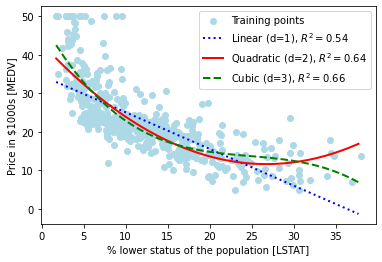

In [53]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightblue')

plt.plot(X_fit, y_lin_fit, 
         label='Linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='Quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='Cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')

#plt.savefig('images/10_12.png', dpi=300)
plt.show()

三次拟合捕捉房价与LSTAT之间的关系优于线性拟合和二次拟合。然而应该意识到，增加越来越多的多项式特征也提高了模型的复杂性，因此增加了过拟合的机会。因此，我们在实践中总是建议在单独的测试数据集上评估模型的泛化性能。

此外，多项式特征对非线性关系建模并非总是最佳的选择。例如，如果我们有一些经验或直觉，只是看看MEDV-LSTAT的散点图就可能会得出这样的假设，LSTAT特征变量的对数变换和MEDV的平方根可能把数据投影到适合线性回归拟合的线性特征空间。例如，我认为这两个变量之间的关系看起来与指数函数相似：

$$f(x)=e^{-x}$$

由于指数函数的自然对数是一条直线，因此我认为这种对数变换用在这里应该很有效：

$$log(f(x))=-x$$


检验这个假设：

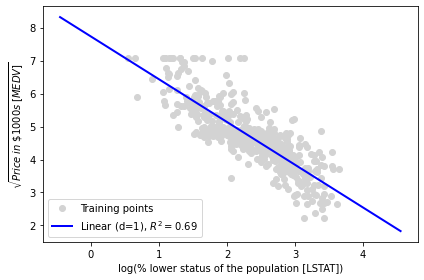

In [54]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='Linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
#plt.savefig('images/10_13.png', dpi=300)
plt.show()

在将解释变量转换到对数空间并把目标变量取平方根之后，我们就能用线性回归捕捉两个变量之间的关系。

这似乎比以前任何多项式特征变换都能更好地拟合数据变量（R2=0.69）

# 用随机森林处理非线性关系

随机森林是多棵决策树的组合，可以理解为**分段线性函数之和**，与以前讨论过的全局性线性和多项式回归模型相反。

通过决策树算法，我们可以进一步将输入空间细分为更小的区域，这些区域也因此变得更易于管理。

## 决策树回归

决策树算法的一个优点是，如果处理非线性数据，它不需要对特征进行任何转换。因为决策树一次只分析一个特征，而不是考虑加权组合。（同样，决策树也不需要归一化或标准化函数）。

在决策树回归的背景下，通常我们也把MSE称为节点方差（within-nodevariance），这就是我们也把分裂标准称为方差缩减（variance reduction）的原因。用scikit-learn实现的DecisionTreeRegressor为变量MEDV和LSTAT之间的非线性关系建立模型，我们看下决策树线拟合的情况：

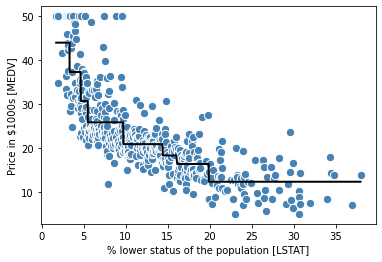

In [55]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
#plt.savefig('images/10_14.png', dpi=300)
plt.show()

决策树捕获了数据中的基本趋势。然而，这种模式的一个局限性在于它并不捕获所需预测的连续性和可微性。此外，在选择树的适当深度值时要小心，既要确保不过拟合也要避免欠拟合。这里深度为3似乎是个不错的选择。

## 随机森林回归

随机森林算法是一种组合了多棵决策树的技术。由于随机性，随机森林通常比单决策树具有更好的泛化性能，这有助于减少模型的方差。随机森林的其他优点还包括它对数据集中的异常值不敏感，而且也不需要太多的参数优化。随机森林中通常唯一需要试验的参数是集成中决策树的棵数。基本的回归随机森林算法，与随机森林分类算法几乎相同，唯一不同的是用MSE准则来培育每棵决策树，并用决策树的平均预测值来计算预测的目标变量。

用住房数据集中的所有特征来拟合随机森林回归模型，采用其中60%的样本做拟合，其余40%的样本做性能评估。

In [56]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [58]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='squared_error', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.394, test: 12.744
R^2 train: 0.984, test: 0.846


随机森林趋向于过拟合训练数据。然而，它仍然能够很好地解释目标变量和解释变量之间的关系（测试数据集R2=0.846）

来看看预测残差：

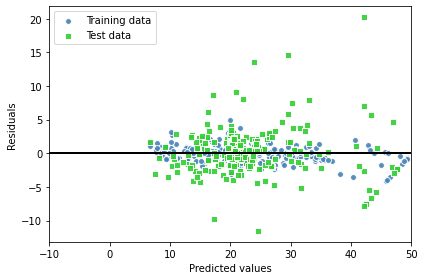

In [59]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()

#plt.savefig('images/10_15.png', dpi=300)
plt.show()

正如R2系数所总结的，如y轴方向上的异常值所示，我们可以看到该模型拟合训练数据要比拟合测试数据更好。

此外，残差分布似乎并不是围绕零中心点完全随机，这表明该模型不能捕捉所有的探索性信息。然而，残差图比本章前面所述的线性模型残差图有了很大的改进。

理想情况下的模型误差应该是随机或不可预测的。换言之，预测误差不应该与解释变量中所包含的任何信息有关，而应反映现实世界的分布或模式的随机性。如果通过检查残差图发现了预测误差中的模式，那就意味着残差图中包含着预测信息。一个常见原因可能是解释性信息泄露到了这些残差中。

幸好现在有处理残差图中非随机性的通用方法，不过这仍然需要试验。取决于能得到的数据，或许能通过转换变量、优化学习算法的超参数、选择更简单或更复杂的模型、除去异常值或者增加额外的变量来改善模型。